In [2]:
import os

os.environ.setdefault("JAX_PLATFORMS", "cpu")

import functools
import pickle
import time
import math  # for cosine schedule

import jax
import jax.numpy as jnp
import jax.random as jr
import optax

# from model_energy_train import Config, load_dataset, xi_pos, eta_pos, L_attn, L_hopf

In [2]:
train_X, train_y, valid_X, valid_y = load_dataset(filename_prefix="parity_data")
with open("model.pkl", "rb") as f:
    params = pickle.load(f)
with open("model_best.pkl", "rb") as f:
    params_best = pickle.load(f)

In [3]:
with open("losses.pkl", "rb") as f:
    losses = pickle.load(f)
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)

In [7]:
losses[1]

[0.6928982138633728,
 0.6925628185272217,
 0.6923964619636536,
 0.6923646330833435,
 0.692401111125946,
 0.6924349665641785,
 0.6924299597740173,
 0.6923883557319641,
 0.6923292875289917,
 0.6922715306282043,
 0.6922277212142944,
 0.6922017335891724,
 0.6921901702880859,
 0.6921849250793457,
 0.6921778321266174,
 0.6921629905700684,
 0.6921391487121582,
 0.6921084523200989,
 0.6920754313468933,
 0.6920443773269653,
 0.6920182704925537,
 0.6919979453086853,
 0.6919814944267273,
 0.6919657588005066,
 0.6919476389884949,
 0.691925585269928,
 0.6918995380401611,
 0.6918715238571167,
 0.6918436884880066,
 0.6918179392814636,
 0.6917948722839355,
 0.691773533821106,
 0.6917521357536316,
 0.6917292475700378,
 0.6917037963867188,
 0.6916767358779907,
 0.6916491389274597,
 0.6916224360466003,
 0.6915972828865051,
 0.6915732026100159,
 0.6915493607521057,
 0.6915247440338135,
 0.6914991736412048,
 0.691473126411438,
 0.6914478540420532,
 0.6914239525794983,
 0.691401481628418,
 0.691379487514495

In [8]:
accs

([0, 100], [0.42307692766189575, 0.5192307829856873])

In [6]:
def infer_forward_euler_with_engergies(params, V0, ctx_bits, save_hist: bool = False):
    """
    Returns:
      V_T: (B, D) terminal visible state
      F_T: (B, D) force at V_T, i.e. dV/dt = -(1/tau_v) * dE/dV at V_T
      E_traj: (T,) scalar energy (sum over batch) recorded at each step

    If save_hist is True, also returns:
      V_traj: (T, B, D) visible states after each update
      H_att_traj: (T, B, L) attention preactivations after each update
      H_hopf_traj: (T, B, M) hopfield preactivations after each update
    """
    # Xi_seq with positive-used xi
    Xi_all = xi_pos(params)  # (vocab_size, D)
    Xi_seq = Xi_all[ctx_bits]  # (B, L, D)
    step_v = Cfg.step_size / Cfg.tau_v
    step_h = Cfg.step_size / Cfg.tau_h

    B = V0.shape[0]

    # Initial pre-activations
    H_att0 = jnp.einsum('bld,bd->bl', Xi_seq, V0) + params['b_att'] # (B, L)
    H_hopf0 = V0 @ eta_pos(params).T + params['c'] # (B, M)

    # Energy for batch with Xi captured (no per-step allocations beyond carry)
    def energy_batch_w_Xi(params, V, H_att, H_hopf, P, A):
        def energy_per_sample_wXi(v, h_att, h_hopf, p, a, Xi_row):
            dv = v - params['a_v']
            vis = 0.5 * jnp.dot(dv, dv)
            XiTp = Xi_row.T @ p  # (D,)
            etaTa = eta_pos(params).T @ a  # (D,)
            coupling = jnp.dot(v, XiTp + etaTa)
            att_bias = jnp.dot(p, h_att - params['b_att'])
            hopf_bias = jnp.dot(a, h_hopf - params['c'])
            return vis - coupling + att_bias + hopf_bias - L_attn(h_att) - L_hopf(h_hopf)

        Eb = jax.vmap(
            energy_per_sample_wXi, in_axes=(0, 0, 0, 0, 0, 0)
        )(V, H_att, H_hopf, P, A, Xi_seq)
        return jnp.sum(Eb)

    grad_E = jax.value_and_grad(energy_batch_w_Xi, argnums=(1, 4, 5))  # grads wrt (V, P, A)

    def grads_activation(V, H_att, H_hopf):
        P = jax.nn.softmax(Cfg.beta * H_att, axis=-1)
        A = jnp.maximum(H_hopf, 0.0)
        E, (dE_dV, dE_dP, dE_dA) = grad_E(params, V, H_att, H_hopf, P, A)
        return dE_dV, dE_dP, dE_dA, E

    def body(i, carry):
        V, H_att, H_hopf, E_traj, V_traj, H_att_traj, H_hopf_traj = carry
        dE_dV, dE_dP, dE_dA, E = grads_activation(V, H_att, H_hopf)
        V = V - step_v * dE_dV
        H_att = H_att - step_h * dE_dP
        H_hopf = H_hopf - step_h * dE_dA

        E_traj = E_traj.at[i].set(E)
        V_traj = V_traj.at[i].set(V)
        H_att_traj = H_att_traj.at[i].set(H_att)
        H_hopf_traj = H_hopf_traj.at[i].set(H_hopf)
        return (V, H_att, H_hopf, E_traj, V_traj, H_att_traj, H_hopf_traj)

    # initialize energy trajectory buffer
    E_traj0 = jnp.zeros((Cfg.n_steps,), dtype=jnp.float32)

    # initialize history buffers (T, B, ...)
    V_traj0 = jnp.zeros((Cfg.n_steps, B, Cfg.D), dtype=jnp.float32)
    H_att_traj0 = jnp.zeros((Cfg.n_steps, B, Cfg.L), dtype=jnp.float32)
    H_hopf_traj0 = jnp.zeros((Cfg.n_steps, B, Cfg.M), dtype=jnp.float32)

    V_T, H_att_T, H_hopf_T, E_traj, V_traj, H_att_traj, H_hopf_traj = jax.lax.fori_loop(
        0, Cfg.n_steps, body, (V0, H_att0, H_hopf0, E_traj0, V_traj0, H_att_traj0, H_hopf_traj0)
    )

    # Force at terminal state (no extra allocations beyond one grad eval)
    dE_dV_T, _, _, _ = grads_activation(V_T, H_att_T, H_hopf_T)
    F_T = -(1.0 / Cfg.tau_v) * dE_dV_T

    if save_hist:
        return V_T, F_T, E_traj, V_traj, H_att_traj, H_hopf_traj
    else:
        return V_T, F_T, E_traj

In [4]:
# Loop through each example in the validation set (same for-loop style as before)
results_val = []
V0 = jnp.zeros((1, Cfg.D))
num_val = int(valid_X.shape[0])
for i in range(num_val):
    ctx = valid_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params, V0, ctx)
    results_val.append(E_traj)
    if (i + 1) % 50 == 0 or i == num_val - 1:
        print(f"processed {i+1}/{num_val} examples; last E0={float(E_traj[0])}")

# Stack into shape (T, num_val)
E_stack_val = jnp.stack(results_val, axis=1)
print('E_stack_val shape:', E_stack_val.shape)

processed 50/52 examples; last E0=-7.888546943664551
processed 52/52 examples; last E0=-7.888546943664551
E_stack_val shape: (1000, 52)


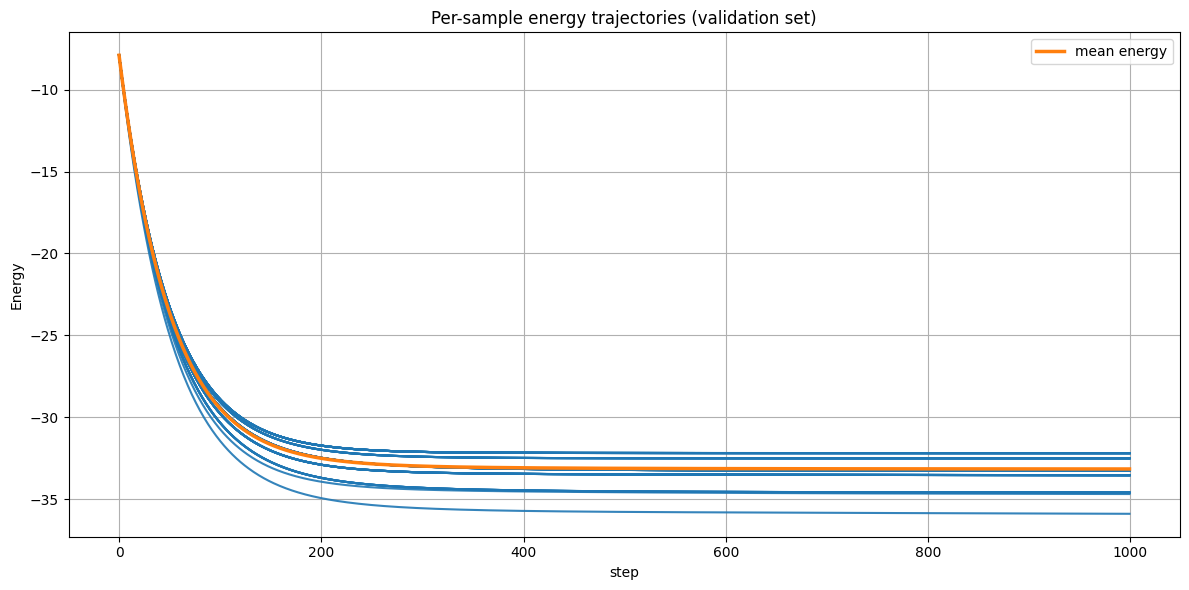

In [5]:
# Final per-sample validation plot (at notebook end)
import matplotlib.pyplot as plt
import numpy as np

# Ensure E_stack_val exists and convert to numpy
E_val = np.array(E_stack_val)
T, N = E_val.shape

plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_val[:, i], color='C0', alpha=0.9)

# Overlay mean trajectory
mean_traj = E_val.mean(axis=1)
plt.plot(mean_traj, color='C1', linewidth=2.5, label='mean energy')

plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (validation set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Loop through each example in the training set (same for-loop style)
results_train = []
V0 = jnp.zeros((1, Cfg.D))
num_train_examples = int(train_X.shape[0])
for i in range(num_train_examples):
    ctx = train_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params, V0, ctx)
    results_train.append(E_traj)
    if (i + 1) % 200 == 0 or i == num_train_examples - 1:
        print(f"processed {i+1}/{num_train_examples} examples; last E0={float(E_traj[0])}")

# Stack into shape (T, num_train_examples)
E_stack_train = jnp.stack(results_train, axis=1)
print('E_stack_train shape:', E_stack_train.shape)

processed 200/204 examples; last E0=-7.888546943664551
processed 204/204 examples; last E0=-7.888546943664551
E_stack_train shape: (1000, 204)


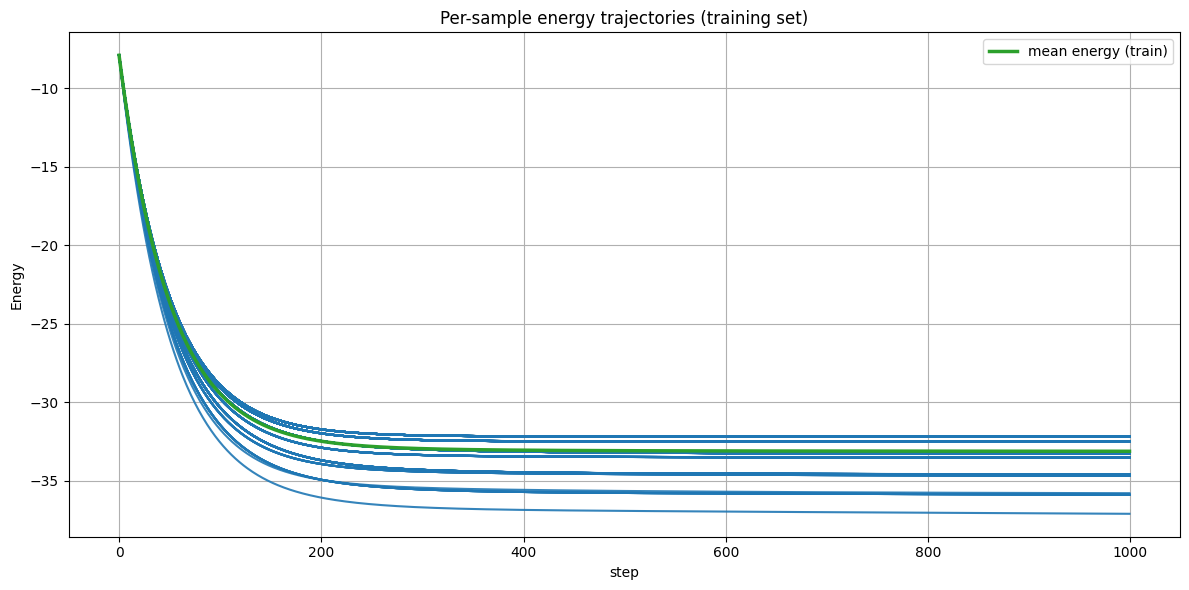

In [7]:
# Plot per-example energy trajectories from the training set in one plot
import matplotlib.pyplot as plt
import numpy as np

E_train = np.array(E_stack_train)
T, N = E_train.shape

plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_train[:, i], color='C0', alpha=0.9)

mean_traj_train = E_train.mean(axis=1)
plt.plot(mean_traj_train, color='C2', linewidth=2.5, label='mean energy (train)')

plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (training set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(best) processed 50/52 val examples; last E0=-7.885663986206055
(best) processed 52/52 val examples; last E0=-7.885663986206055
E_stack_val_best shape: (1000, 52)


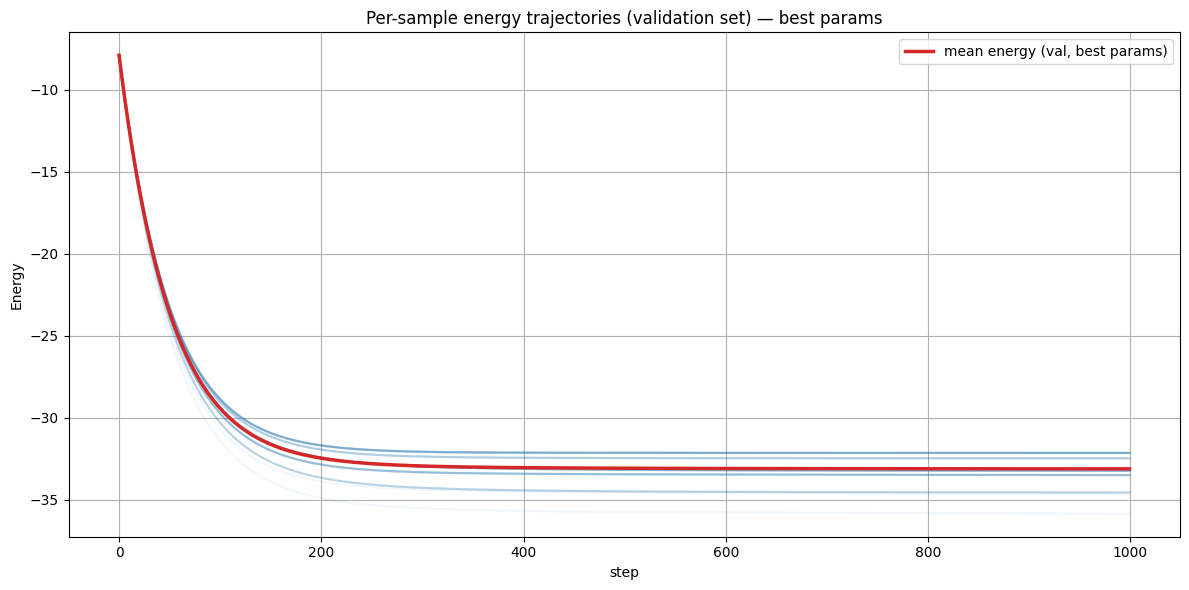

In [8]:
# Load saved best parameters and plot per-sample energy trajectories on validation set
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open('model_best.pkl', 'rb') as f:
    params_best = pickle.load(f)

# Per-sample inference on validation set using params_best
results_val_best = []
V0 = jnp.zeros((1, Cfg.D))
num_val = int(valid_X.shape[0])
for i in range(num_val):
    ctx = valid_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params_best, V0, ctx)
    results_val_best.append(E_traj)
    if (i + 1) % 50 == 0 or i == num_val - 1:
        print(f"(best) processed {i+1}/{num_val} val examples; last E0={float(E_traj[0])}")

E_stack_val_best = jnp.stack(results_val_best, axis=1)
print('E_stack_val_best shape:', E_stack_val_best.shape)

# Plot all per-sample validation trajectories with mean overlay
E_val_best = np.array(E_stack_val_best)
T, N = E_val_best.shape
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_val_best[:, i], color='C0', alpha=0.06)
mean_val_best = E_val_best.mean(axis=1)
plt.plot(mean_val_best, color='C3', linewidth=2.5, label='mean energy (val, best params)')
plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (validation set) — best params')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(best) processed 200/204 train examples; last E0=-7.885663986206055
(best) processed 204/204 train examples; last E0=-7.885663986206055
E_stack_train_best shape: (1000, 204)


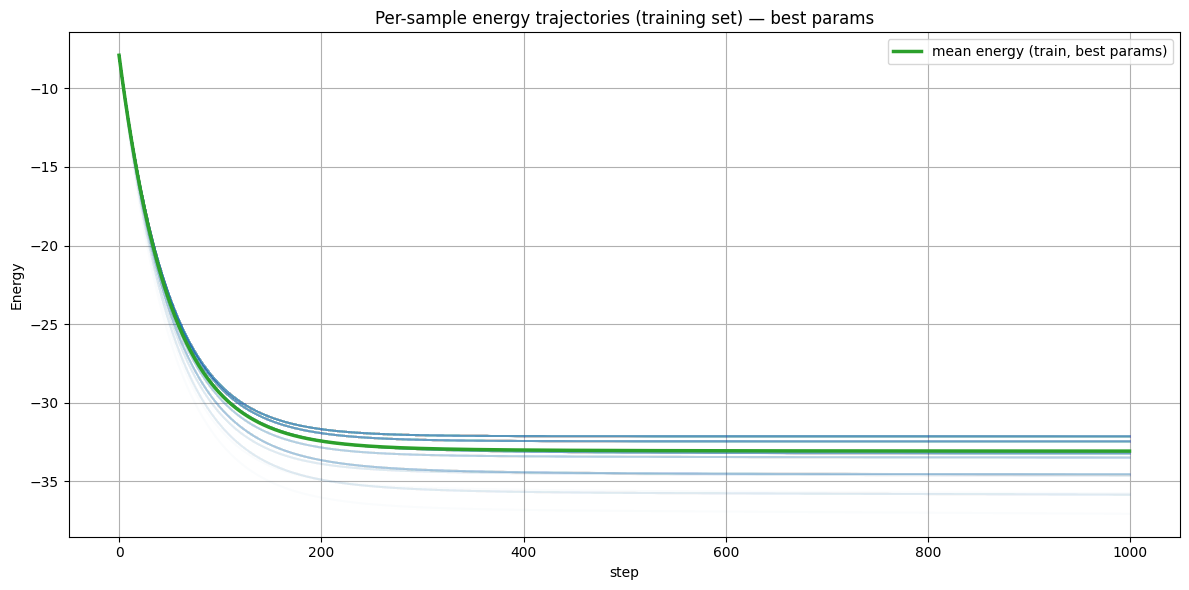

In [9]:
# Per-sample inference on training set using params_best and plot
results_train_best = []
V0 = jnp.zeros((1, Cfg.D))
num_train_examples = int(train_X.shape[0])
for i in range(num_train_examples):
    ctx = train_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params_best, V0, ctx)
    results_train_best.append(E_traj)
    if (i + 1) % 200 == 0 or i == num_train_examples - 1:
        print(f"(best) processed {i+1}/{num_train_examples} train examples; last E0={float(E_traj[0])}")

E_stack_train_best = jnp.stack(results_train_best, axis=1)
print('E_stack_train_best shape:', E_stack_train_best.shape)

# Plot per-sample training trajectories
E_train_best = np.array(E_stack_train_best)
T, N = E_train_best.shape
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_train_best[:, i], color='C0', alpha=0.02)
mean_traj_train_best = E_train_best.mean(axis=1)
plt.plot(mean_traj_train_best, color='C2', linewidth=2.5, label='mean energy (train, best params)')
plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (training set) — best params')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

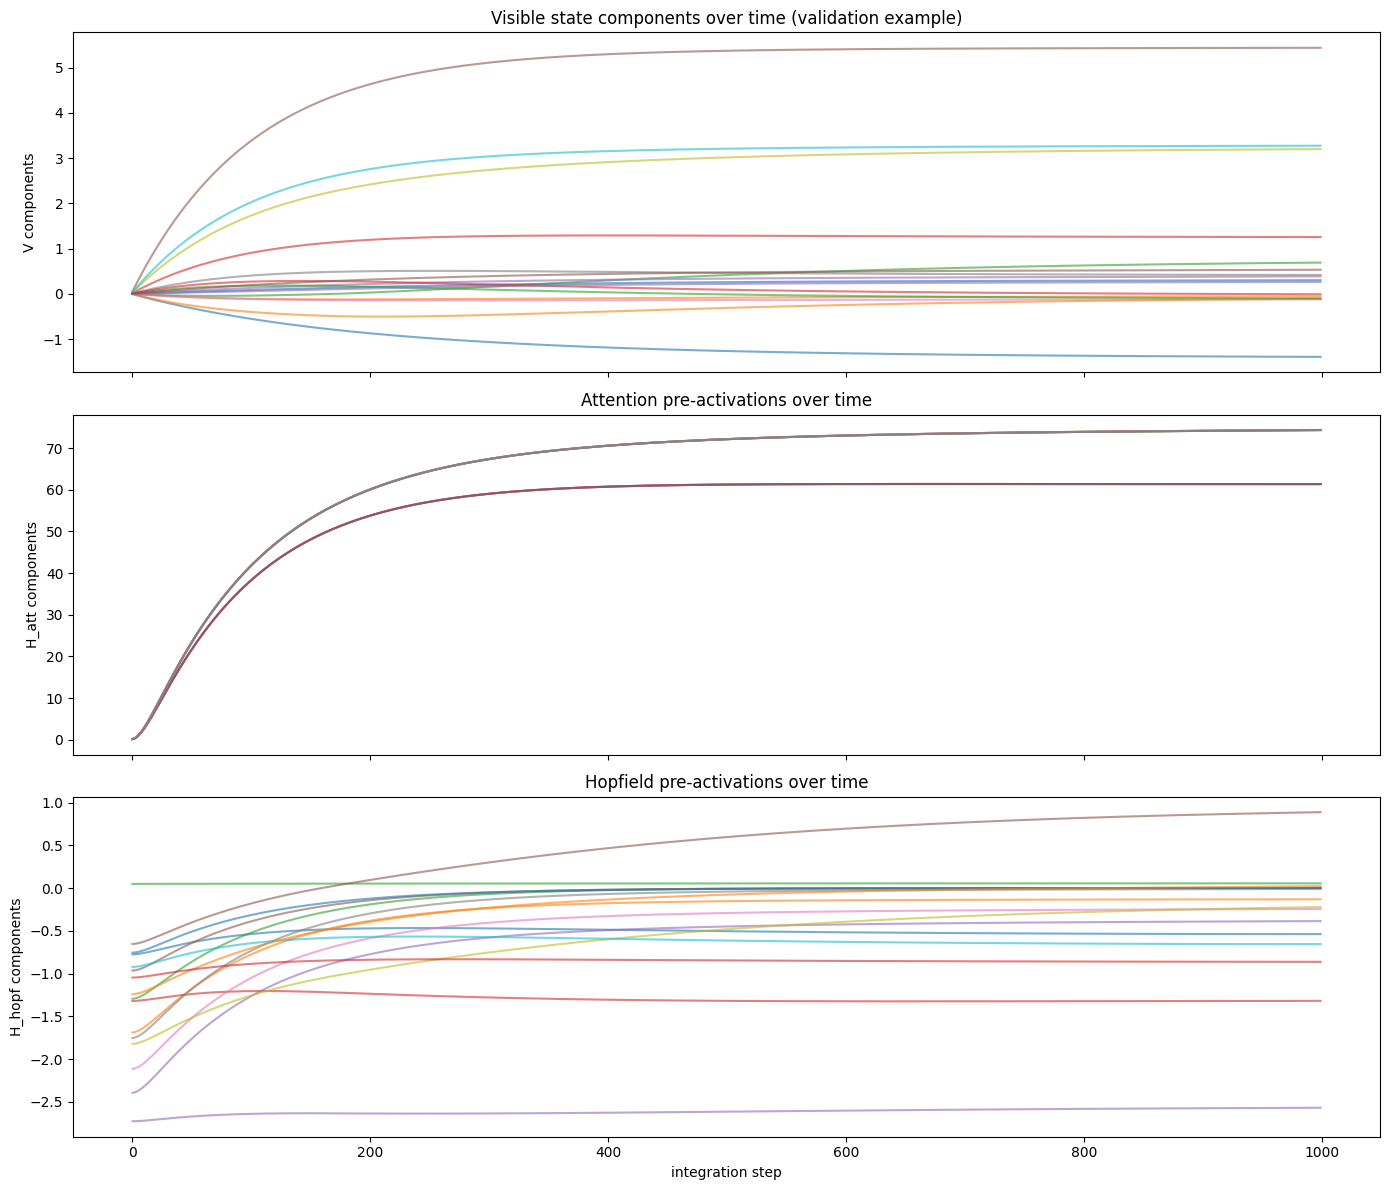

In [10]:
# Run infer_forward_euler_with_engergies on a single validation example with history saving and plot trajectories
import pickle
import numpy as np
import matplotlib.pyplot as plt

# choose first validation example
ctx = valid_X[0:1]
V0 = jnp.zeros((1, Cfg.D))

# run with history
V_T_s, F_T_s, E_traj_s, V_traj_s, H_att_traj_s, H_hopf_traj_s = infer_forward_euler_with_engergies(
    params, V0, ctx, save_hist=True
)

# convert and squeeze batch dim: (T, B, dim) -> (T, dim)
V_traj_np = np.array(V_traj_s).squeeze(axis=1)
H_att_traj_np = np.array(H_att_traj_s).squeeze(axis=1)
H_hopf_traj_np = np.array(H_hopf_traj_s).squeeze(axis=1)
T = V_traj_np.shape[0]

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Visible components
for d in range(V_traj_np.shape[1]):
    axs[0].plot(np.arange(T), V_traj_np[:, d], alpha=0.6)
axs[0].set_ylabel('V components')
axs[0].set_title('Visible state components over time (validation example)')

# Attention preactivations
for l in range(H_att_traj_np.shape[1]):
    axs[1].plot(np.arange(T), H_att_traj_np[:, l], alpha=0.8)
axs[1].set_ylabel('H_att components')
axs[1].set_title('Attention pre-activations over time')

# Hopfield preactivations
for m in range(H_hopf_traj_np.shape[1]):
    axs[2].plot(np.arange(T), H_hopf_traj_np[:, m], alpha=0.6)
axs[2].set_ylabel('H_hopf components')
axs[2].set_title('Hopfield pre-activations over time')
axs[2].set_xlabel('integration step')

plt.tight_layout()
plt.show()

processed 50/52 validation examples
processed 52/52 validation examples


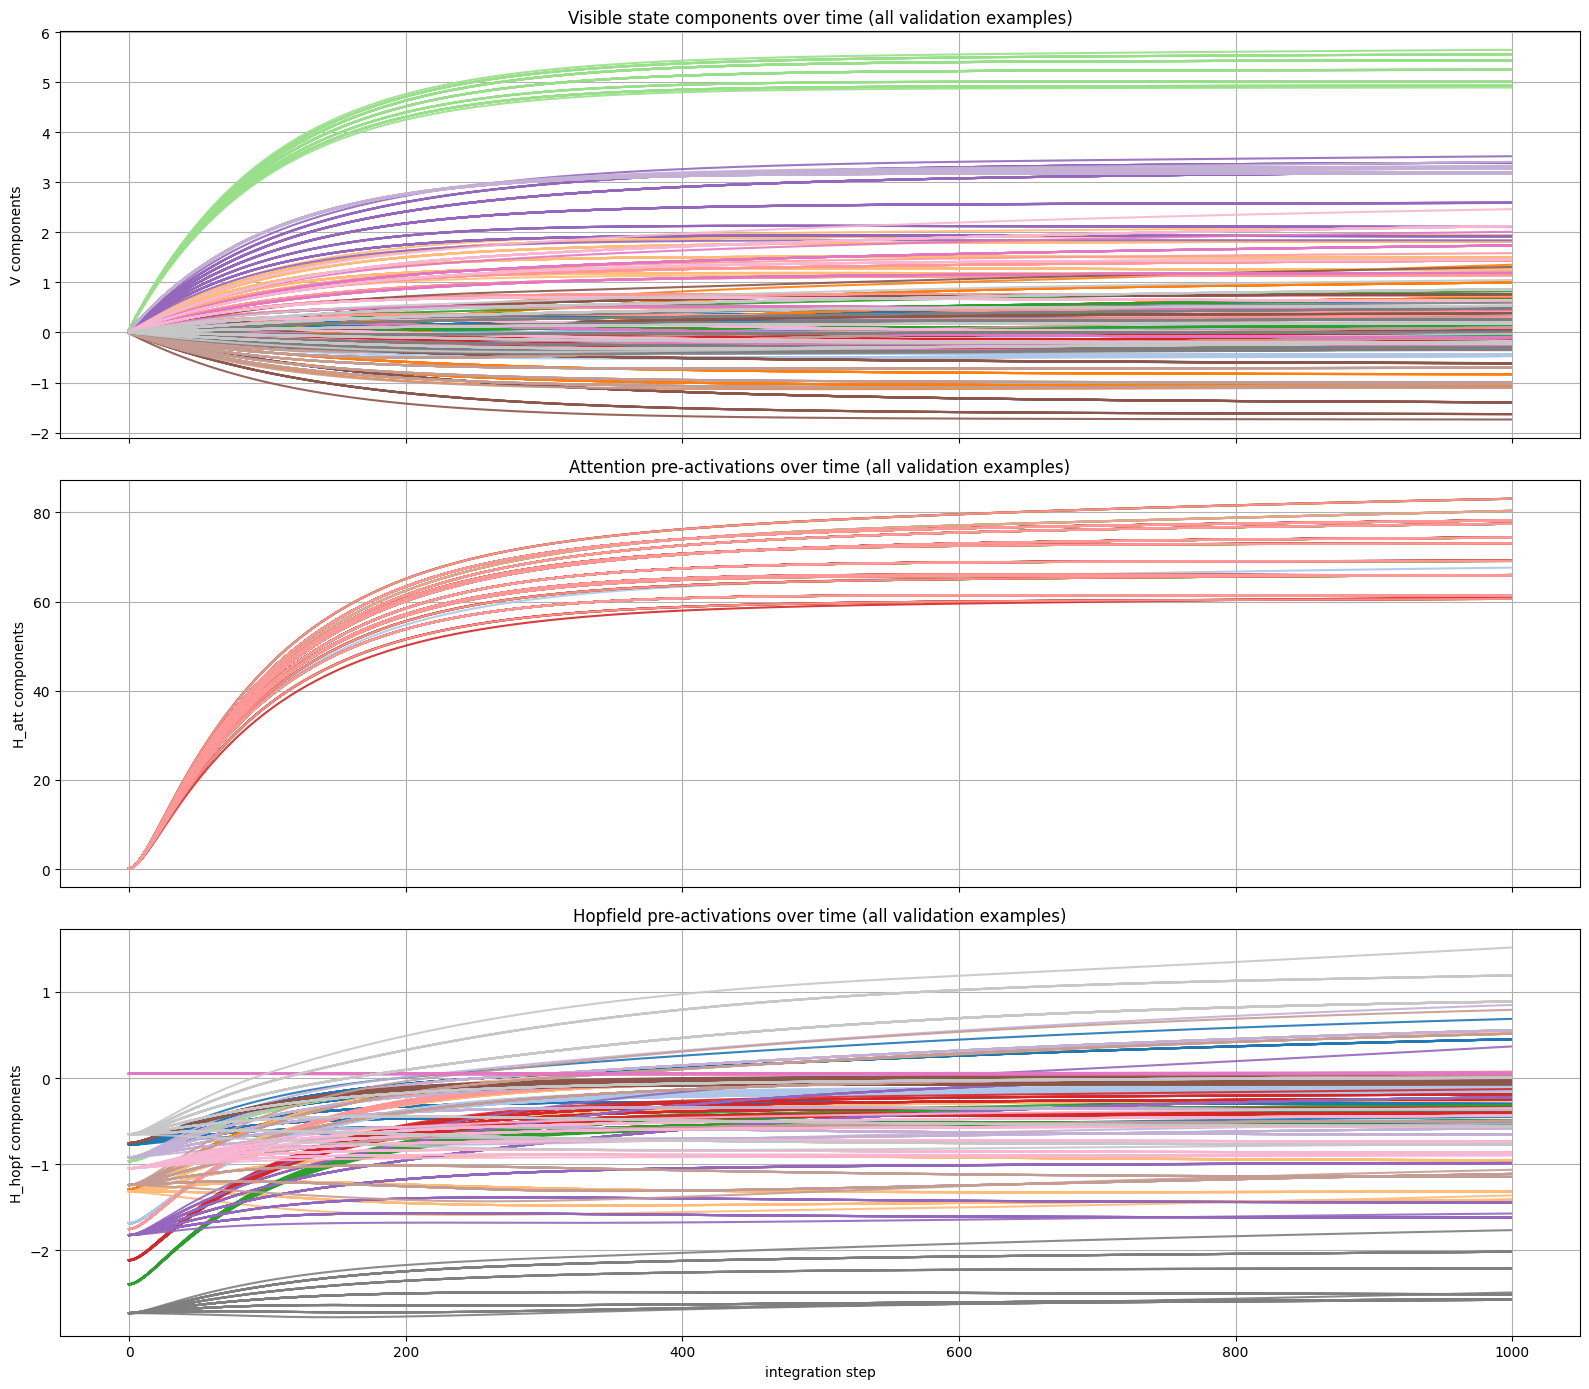

In [11]:
# Run infer_forward_euler_with_engergies over the entire validation set, save histories, and plot components for all examples
import pickle
import numpy as np
import matplotlib.pyplot as plt

V0 = jnp.zeros((1, Cfg.D))
num_val = int(valid_X.shape[0])

results_V = []
results_H_att = []
results_H_hopf = []

for i in range(num_val):
    ctx = valid_X[i:i+1]
    V_T, F_T, E_traj, V_traj, H_att_traj, H_hopf_traj = infer_forward_euler_with_engergies(
        params, V0, ctx, save_hist=True
    )
    # squeeze batch axis -> (T, dim)
    results_V.append(np.array(V_traj).squeeze(axis=1))
    results_H_att.append(np.array(H_att_traj).squeeze(axis=1))
    results_H_hopf.append(np.array(H_hopf_traj).squeeze(axis=1))

    if (i + 1) % 50 == 0 or i == num_val - 1:
        print(f"processed {i+1}/{num_val} validation examples")

# Stack into arrays with shape (T, num_val, dim)
# results lists are length num_val of arrays (T, dim)
V_all = np.stack(results_V, axis=1)        # (T, num_val, D)
H_att_all = np.stack(results_H_att, axis=1)  # (T, num_val, L)
H_hopf_all = np.stack(results_H_hopf, axis=1) # (T, num_val, M)

T = V_all.shape[0]

# Plotting: for each component dimension, plot per-example traces (low alpha) and mean trace bold
fig, axs = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# colormap
cmap = plt.get_cmap('tab20')

# V components
for d in range(V_all.shape[2]):
    color = cmap(d % cmap.N)
    # per-example traces
    for n in range(V_all.shape[1]):
        axs[0].plot(np.arange(T), V_all[:, n, d], color=color, alpha=0.9)
    # # mean across examples
    # mean_d = V_all[:, :, d].mean(axis=1)
    # axs[0].plot(np.arange(T), mean_d, color=color, linewidth=1.5, label=f'V[{d}] mean')

axs[0].set_title('Visible state components over time (all validation examples)')
axs[0].set_ylabel('V components')
# axs[0].legend(ncol=4, fontsize='small')
axs[0].grid(True)

# H_att components
for l in range(H_att_all.shape[2]):
    color = cmap(l % cmap.N)
    for n in range(H_att_all.shape[1]):
        axs[1].plot(np.arange(T), H_att_all[:, n, l], color=color, alpha=0.9)
    # mean_l = H_att_all[:, :, l].mean(axis=1)
    # axs[1].plot(np.arange(T), mean_l, color=color, linewidth=1.5, label=f'H_att[{l}] mean')

axs[1].set_title('Attention pre-activations over time (all validation examples)')
axs[1].set_ylabel('H_att components')
# axs[1].legend(ncol=4, fontsize='small')
axs[1].grid(True)

# H_hopf components
for m in range(H_hopf_all.shape[2]):
    color = cmap(m % cmap.N)
    for n in range(H_hopf_all.shape[1]):
        axs[2].plot(np.arange(T), H_hopf_all[:, n, m], color=color, alpha=0.9)
    # mean_m = H_hopf_all[:, :, m].mean(axis=1)
    # axs[2].plot(np.arange(T), mean_m, color=color, linewidth=1.5, label=f'H_hopf[{m}] mean')

axs[2].set_title('Hopfield pre-activations over time (all validation examples)')
axs[2].set_ylabel('H_hopf components')
axs[2].set_xlabel('integration step')
# axs[2].legend(ncol=4, fontsize='small')
axs[2].grid(True)

plt.tight_layout()
plt.show()